# Fine-Tuning a T5-Base Model for News Summarization

### Addressing Compatibility Challenges with `SimpleT5`

In this notebook, we will fine-tune a `t5-base` model to summarize news articles. Before we proceed, we need to address a compatibility issue. The `SimpleT5` package requires [version 4.16](https://github.com/Shivanandroy/simpleT5/blob/main/setup.py#L46) of the `transformers` library, but the current version is 4.42. Unfortunately, the newer version does not include the `cached_path` function, which is crucial for the `SimpleT5` package to function correctly.

To resolve this, we will manually add the `cached_path` function to the current version of `transformers`. Here is the [source code](https://huggingface.co/transformers/v3.1.0/_modules/transformers/file_utils.html) for `transformers` version 3.1, which includes the `cached_path` function we need.

You have two options:
1. Extract only the `cached_path` function along with its dependencies and add it to the current `transformers.file_utils`.
2. Concatenate the entire `file_utils` module from both versions. Note that this approach is only recommended if you do not plan to use the `transformers` library later, as it may cause conflicts with other functions due to the concatenation.

### Extracting Required Files

First, we will extract the necessary files: the `transformers.file_utils` from version 3.1, which I have already saved in a [GitHub repository](https://github.com/MhGhobashy/Transformers-utils/tree/main), and the current `transformers.file_utils` from the installed version.

In [1]:
!wget https://raw.githubusercontent.com/MhGhobashy/Transformers-utils/main/transformers_v3_file_utlis.py -O transformers_v3_file_utlis.py
!cp /opt/conda/lib/python3.10/site-packages/transformers/file_utils.py /kaggle/working/file_utils.py

--2024-07-22 20:17:09--  https://raw.githubusercontent.com/MhGhobashy/Transformers-utils/main/transformers_v3_file_utlis.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37451 (37K) [text/plain]
Saving to: 'transformers_v3_file_utlis.py'

transformers_v3_fil 100%[===================>]  36.57K  --.-KB/s    in 0.01s   

2024-07-22 20:17:09 (3.51 MB/s) - 'transformers_v3_file_utlis.py' saved [37451/37451]



In [2]:
# Combining the Content of Both Files

# Read the custom file
with open('/kaggle/working/transformers_v3_file_utlis.py', 'r') as custom_file:
    custom_code = custom_file.read()

# Read the original file
with open('/kaggle/working/file_utils.py', 'r') as original_file:
    original_code = original_file.read()

# Write combined code to a new file
with open('/kaggle/working/file_utils_combined.py', 'w') as combined_file:
    combined_file.write('# Original file content\n')
    combined_file.write(original_code)
    combined_file.write('\n# Custom file content\n')
    combined_file.write(custom_code)

In [3]:
# Update the current file_utils

!cp /kaggle/working/file_utils_combined.py /opt/conda/lib/python3.10/site-packages/transformers/file_utils.py

#### Now since we've fixed that issue, let's dive right in
# Import necessary libraries:

In [4]:
#!pip install spacy      # Uncomment these two lines if you are using a CPU or TPU
#!python -m spacy download en_core_web_sm
import os
import re
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

2024-07-22 20:17:25.552672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 20:17:25.552816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 20:17:25.733678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def read_files_from_folder(folder_path):
    """
    Reads text files from subfolders in the specified folder path.

    Args:
        folder_path (str): The path to the main folder containing subfolders for different categories.

    Returns:
        list: A list of tuples, each containing the category, filename, and content of a file.
    """
    
    data = []
    categories = ['business', 'entertainment', 'politics', 'sport', 'tech']
    
    for category in categories:
        category_path = os.path.join(folder_path, category)
        if os.path.exists(category_path):
            print(f"Reading files from category: {category}")
            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)
                if os.path.isfile(file_path):
                    try:
                        with open(file_path, 'r', encoding='utf-8') as file:
                            content = file.read()
                    except UnicodeDecodeError:
                        with open(file_path, 'r', encoding='ISO-8859-1') as file:
                            content = file.read()
                    data.append((category, filename, content))
        else:
            print(f"Category folder not found: {category_path}")
                    
    return data

# Paths to the folders
articles_folder = '/kaggle/input/bbc-news-summary/BBC News Summary/News Articles'
summaries_folder = '/kaggle/input/bbc-news-summary/BBC News Summary/Summaries'

# Read the data
articles_data = read_files_from_folder(articles_folder)
summaries_data = read_files_from_folder(summaries_folder)

# Check if data is read correctly
print(f"Number of articles read: {len(articles_data)}")
print(f"Number of summaries read: {len(summaries_data)}")

# Create DataFrames
df_articles = pd.DataFrame(articles_data, columns=['Category', 'Filename', 'Article'])
df_summaries = pd.DataFrame(summaries_data, columns=['Category', 'Filename', 'Summary'])

# Merge the DataFrames on 'Category' and 'Filename'
data = pd.merge(df_articles, df_summaries, on=['Category', 'Filename'])
data.head()

Reading files from category: business
Reading files from category: entertainment
Reading files from category: politics
Reading files from category: sport
Reading files from category: tech
Reading files from category: business
Reading files from category: entertainment
Reading files from category: politics
Reading files from category: sport
Reading files from category: tech
Number of articles read: 2225
Number of summaries read: 2225


,Category,Filename,Article,Summary
0,business,361.txt,US consumer confidence up\n\nConsumers' confid...,"Wal-Mart, the largest US retailer, has said it..."
1,business,245.txt,The 'ticking budget' facing the US\n\nThe budg...,Brute force budget cuts or spending caps would...
2,business,431.txt,Mitsubishi in Peugeot link talks\n\nTrouble-hi...,Trouble-hit Mitsubishi Motors is in talks with...
3,business,141.txt,BMW reveals new models pipeline\n\nBMW is prep...,Typically it takes about three years from when...
4,business,487.txt,World leaders gather to face uncertainty\n\nMo...,"More than 2,000 business and political leaders..."


In [6]:
df = data[['Article', 'Summary']].copy() # Create a copy of the relevant columns (Article and Summary)
print(df.shape)
df.drop_duplicates(inplace=True)
df.dropna(axis=0,inplace=True)
print(df.shape)

(2225, 2)
(2127, 2)


# Preprocessing:

In [7]:
# Load the spaCy English model and set up the stop_words
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words

In [8]:
# Setting up the contraction_mapping to get rid of contractions in the text
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
def text_cleaner(text, num):
    """
    Cleans a text by performing various preprocessing steps such as removing unnecessary elements and normalizing the text.

    Args:
        text (str): The input text to be cleaned.
        num (int): A flag indicating whether to remove stopwords (0) or not (1).

    Returns:
        str: The cleaned and processed text.
    """
    # Replace newline characters with spaces
    text = text.replace('\n', ' ').replace('\n\n', ' ')
    
    # Convert to lowercase
    newString = text.lower()
    
    # Remove content within parentheses
    newString = re.sub(r'\([^)]*\)', '', newString)
    
    # Remove double quotes
    newString = re.sub('"', '', newString)
    
    # Replace contractions with their full forms
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    
    # Remove "'s" from words
    newString = re.sub(r"'s\b", "", newString)
    
    # Remove non-alphabetic characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    
    # Replace multiple occurrences of 'm' with 'mm'
    newString = re.sub('[m]{2,}', 'mm', newString)

    # Tokenize and remove stop words (if num == 0)
    if num == 0:
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens = newString.split()
    
    # Keep only words with more than one character
    long_words = [i for i in tokens if len(i) > 1]
    return (" ".join(long_words)).strip()

In [10]:
cleaned_texts = []

# clean articles
for t in df["Article"]:
    cleaned_texts.append(text_cleaner(t, 0)) # 0 to remove the stop words and get rid of unnecessary words

# clean summaries
cleaned_summaries = []

for s in df["Summary"]:
    cleaned_summaries.append(text_cleaner(s, 1)) #1 to retain most of the summarized text

# create new dataframe for the cleaned texts and summaries 
dataframe = pd.DataFrame(columns=["text", "summary"])

# put cleaned version of texts and summaries into the dataframe
dataframe["text"] = cleaned_texts
dataframe["summary"] = cleaned_summaries

In [11]:
dataframe.head()

,text,summary
0,consumer confidence consumers confidence state...,wal mart the largest us retailer has said its ...
1,ticking budget facing budget proposals laid ad...,brute force budget cuts or spending caps would...
2,mitsubishi peugeot link talks trouble hit mits...,trouble hit mitsubishi motors is in talks with...
3,bmw reveals new models pipeline bmw preparing ...,typically it takes about three years from when...
4,world leaders gather face uncertainty business...,more than business and political leaders from ...


In [12]:
dataframe.replace('', np.nan, inplace=True)
dataframe.dropna(axis=0,inplace=True)

#### This next function helps in filtering out outlier texts that exceed a specified length threshold.

In [13]:
def text_length_percentile(df, text_column, percentile):
    """
    Calculate the text length at which a given percentile of texts are below that length.
    
    Args:
    df (pandas.DataFrame): The DataFrame containing the text data.
    text_column (str): The column name containing the text data.
    percentile (float): The percentile to calculate (between 0 and 100).
    
    Returns:
    int: The text length at the given percentile.
    """
    # Calculate the length of each text
    text_lengths = df[text_column].apply(lambda x: len(x.split()))
    
    # Calculate the length at the given percentile
    length_at_percentile = np.percentile(text_lengths, percentile)
    
    return int(length_at_percentile)

percentile = 90

length_at_the_percentile = text_length_percentile(dataframe, 'text', percentile)
print(f"{percentile}% of the texts are below this length: {length_at_the_percentile}")

length_at_the_percentile = text_length_percentile(dataframe, 'summary', percentile)
print(f"{percentile}% of the summaries are below this length: {length_at_the_percentile}")

90% of the texts are below this length: 313
90% of the summaries are below this length: 269


In [14]:
MAX_TEXT_LEN = 315
MAX_SUMMARY_LEN = 270

### Remove outliers and rename columns

#### The Simple T5 library expects the source data (the input text) to be under the `source_text` column and the target data (the output text) to be under the `target_text` column. This standardized format simplifies the data preprocessing and training steps, ensuring that the data is correctly fed into the model without additional modifications.

In [15]:
cleaned_text = np.array(dataframe["text"])
cleaned_summary = np.array(dataframe["summary"])

# define lists for short text and short summaries
short_text = []
short_summary = []

# clean outliers
for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= MAX_SUMMARY_LEN and len(cleaned_text[i].split()) <= MAX_TEXT_LEN):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

# change the dataframe
final_dataframe = pd.DataFrame({"source_text":short_text, "target_text":short_summary})

In [16]:
dataframe.shape, final_dataframe.shape

((2127, 2), (1880, 2))

### After removing the outliers, we will lemmatize the remaining text to further clean and normalize the input.

In [17]:
%%time
def lemmatize_text(text):
    doc = nlp(text)
    # Return lemmatized text
    return ' '.join([token.lemma_ for token in doc])

# Apply lemmatization function to DataFrame column
final_dataframe['source_text'] = final_dataframe['source_text'].apply(lemmatize_text)
final_dataframe['target_text'] = final_dataframe['target_text'].apply(lemmatize_text)
final_dataframe.head()

CPU times: user 1min 39s, sys: 38.1 ms, total: 1min 39s
Wall time: 1min 39s


,source_text,target_text
0,consumer confidence consumer confidence state ...,wal mart the large us retailer have say its de...
1,mitsubishi peugeot link talk trouble hit mitsu...,trouble hit mitsubishi motors be in talk with ...
2,bmw reveal new model pipeline bmw prepare ente...,typically it take about three year from when d...
3,madagascar complete currency switch madagascar...,madagascar have complete the replacement of it...
4,trouble marsh sec scrutiny stock market regula...,the us stock market regulator be investigate t...


### The T5 model requires a prompt before the input text. In this case, we use the prompt "summarize: ".

In [18]:
final_dataframe["source_text"] = final_dataframe["source_text"].apply(lambda x: "summarize: " + x)

In [19]:
final_dataframe.head()

,source_text,target_text
0,summarize: consumer confidence consumer confid...,wal mart the large us retailer have say its de...
1,summarize: mitsubishi peugeot link talk troubl...,trouble hit mitsubishi motors be in talk with ...
2,summarize: bmw reveal new model pipeline bmw p...,typically it take about three year from when d...
3,summarize: madagascar complete currency switch...,madagascar have complete the replacement of it...
4,summarize: trouble marsh sec scrutiny stock ma...,the us stock market regulator be investigate t...


In [20]:
train_df, test_df = train_test_split(final_dataframe, test_size = 0.25)
train_df.shape, test_df.shape

((1410, 2), (470, 2))

### The data is now prepared and ready for input into the T5 model.

# T5 model fine-tuning:

In [21]:
# !pip install simplet5

#### There's five different sizes of the T5 model:
##### * T5-Small: 60 million parameters
##### * T5-Base: 220 million parameters
##### * T5-Large: 770 million parameters
##### * T5-3B: 3 billion parameters
##### * T5-11B: 11 billion parameters
#### We will use T5-Base to speed up the fine-tuning process

In [22]:
# from simplet5 import SimpleT5

# model = SimpleT5()
# model.from_pretrained(model_type='t5', model_name='t5-base')

In [23]:
# %%time
# import torch
# torch.cuda.empty_cache()

# model.train(
#     train_df=train_df, 
#     eval_df=test_df[:400],
#     source_max_token_len=MAX_TEXT_LEN,
#     target_max_token_len=MAX_SUMMARY_LEN,
#     batch_size=8,
#     max_epochs=17,
#     use_gpu=True)

`CPU times: user 47min 26s, sys: 18min 43s, total: 1h 6min 9s
Wall time: 1h 6min 17s`

In [24]:
# ! (cd outputs; ls )

```! (cd outputs; ls )
simplet5-epoch-0-train-loss-2.4903-val-loss-1.8153
simplet5-epoch-1-train-loss-1.8652-val-loss-1.6588
simplet5-epoch-10-train-loss-1.0514-val-loss-1.4975
simplet5-epoch-11-train-loss-1.0006-val-loss-1.5135
simplet5-epoch-12-train-loss-0.9491-val-loss-1.5405
simplet5-epoch-13-train-loss-0.8967-val-loss-1.5245
simplet5-epoch-14-train-loss-0.8542-val-loss-1.5522
simplet5-epoch-15-train-loss-0.8125-val-loss-1.5761
simplet5-epoch-16-train-loss-0.7789-val-loss-1.5789
simplet5-epoch-2-train-loss-1.6834-val-loss-1.5941
simplet5-epoch-3-train-loss-1.5657-val-loss-1.5481
simplet5-epoch-4-train-loss-1.4645-val-loss-1.5223
simplet5-epoch-5-train-loss-1.3753-val-loss-1.5014
simplet5-epoch-6-train-loss-1.3017-val-loss-1.4917
simplet5-epoch-7-train-loss-1.233-val-loss-1.4867
simplet5-epoch-8-train-loss-1.1677-val-loss-1.4869
simplet5-epoch-9-train-loss-1.1051-val-loss-1.489```

### We have fine-tuned the T5-Base model over 17 epochs on our dataset. 
### Next, we will evaluate which epoch performed best by calculating the cosine similarity between the summaries generated by the T5-Base model in each epoch and the original summaries in the dataset.

In [25]:
# !pip install sentencepiece   # Uncomment this if you're using CPU or TPU

In [26]:
# def calculate_cosine_similarity(models_folder, test_text, real_summary):
#     """
#     Goes though the output dir, calculating the cosine similarity between the generated summaries from different models 
#     and a real summary, and identify the model with the highest similarity.

#     Args:
#         models_folder (str): The folder containing the pre-trained T5 epoches.
#         test_text (str): The input text to generate the summary from.
#         real_summary (str): The reference summary to compare against.

#     Returns:
#         None: Prints the model name with the highest cosine similarity and its similarity score.
        
#     """
    
#     best_model_name = None
#     best_cosine_sim = -1
    
#     # Loop through all models in the specified folder
#     for model_name in os.listdir(models_folder):
#         model_path = os.path.join(models_folder, model_name)
        
#         if os.path.isdir(model_path):
#             # Load the tokenizer and model
#             tokenizer = T5Tokenizer.from_pretrained(model_path)
#             model = T5ForConditionalGeneration.from_pretrained(model_path)
            
#             # Encode the test text
#             input_ids = tokenizer.encode(test_text, return_tensors='pt')
            
#             # Define generation parameters
#             max_length = 320  # Increase max_length
#             min_length = 150  # Increase min_length
#             num_beams = 4     # Use beam search with num_beams
            
#             # Generate summary with adjusted parameters
#             outputs = model.generate(input_ids, max_length=max_length, min_length=min_length, num_beams=num_beams, length_penalty=2.0, early_stopping=True)
#             summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
            
#             # Convert texts to TF-IDF vectors
#             vectorizer = TfidfVectorizer()
#             tfidf_matrix = vectorizer.fit_transform([real_summary, summary])
            
#             # Compute cosine similarity
#             cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])
#             cosine_sim_value = cosine_sim[0][0]
#             print(f"Cosine Similarity between Reference and Summary for model {model_name}: {cosine_sim_value}")
            
#             # Update the best model if the current model has a higher cosine similarity
#             if cosine_sim_value > best_cosine_sim:
#                 best_cosine_sim = cosine_sim_value
#                 best_model_name = model_name

#     print(f"Best model: {best_model_name} with a cosine similarity of {best_cosine_sim}")


# models_folder = '/kaggle/working/outputs'
# test_text = test_df.source_text.iloc[425]
# real_summary = test_df.target_text.iloc[425]
# calculate_cosine_similarity(models_folder, test_text, real_summary)

#### This is the output of the previous cell:

* Cosine Similarity between Reference and Summary for model simplet5-epoch-12-train-loss-0.9491-val-loss-1.5405: 0.8617982465980492

* Cosine Similarity between Reference and Summary for model simplet5-epoch-7-train-loss-1.233-val-loss-1.4867: 0.814559582030233

* Cosine Similarity between Reference and Summary for model simplet5-epoch-2-train-loss-1.6834-val-loss-1.5941: 0.7414822898838794

* Cosine Similarity between Reference and Summary for model simplet5-epoch-11-train-loss-1.0006-val-loss-1.5135: 0.6593842806840363

* Cosine Similarity between Reference and Summary for model simplet5-epoch-6-train-loss-1.3017-val-loss-1.4917: 0.6798618549410862

* Cosine Similarity between Reference and Summary for model simplet5-epoch-13-train-loss-0.8967-val-loss-1.5245: 0.7776923936124253

* Cosine Similarity between Reference and Summary for model simplet5-epoch-4-train-loss-1.4645-val-loss-1.5223: 0.7768362373100459

* Cosine Similarity between Reference and Summary for model simplet5-epoch-10-train-loss-1.0514-val-loss-1.4975: 0.5869880094563229

* Cosine Similarity between Reference and Summary for model simplet5-epoch-3-train-loss-1.5657-val-loss-1.5481: 0.6621888869560856

* Cosine Similarity between Reference and Summary for model simplet5-epoch-14-train-loss-0.8542-val-loss-1.5522: 0.823627154485825

* Cosine Similarity between Reference and Summary for model simplet5-epoch-15-train-loss-0.8125-val-loss-1.5761: 0.7660547794165619

* Cosine Similarity between Reference and Summary for model simplet5-epoch-8-train-loss-1.1677-val-loss-1.4869: 0.6645936278771558

* Cosine Similarity between Reference and Summary for model simplet5-epoch-9-train-loss-1.1051-val-loss-1.489: 0.765228661458173

* Cosine Similarity between Reference and Summary for model simplet5-epoch-16-train-loss-0.7789-val-loss-1.5789: 0.767892020756268

* Cosine Similarity between Reference and Summary for model simplet5-epoch-0-train-loss-2.4903-val-loss-1.8153: 0.6266695790592046

* Cosine Similarity between Reference and Summary for model simplet5-epoch-5-train-loss-1.3753-val-loss-1.5014: 0.6895926312429574

* Cosine Similarity between Reference and Summary for model simplet5-epoch-1-train-loss-1.8652-val-loss-1.6588: 0.6108410339674814

**Best model**: simplet5-epoch-12-train-loss-0.9491-val-loss-1.5405 with a cosine similarity of 0.8617982465980492


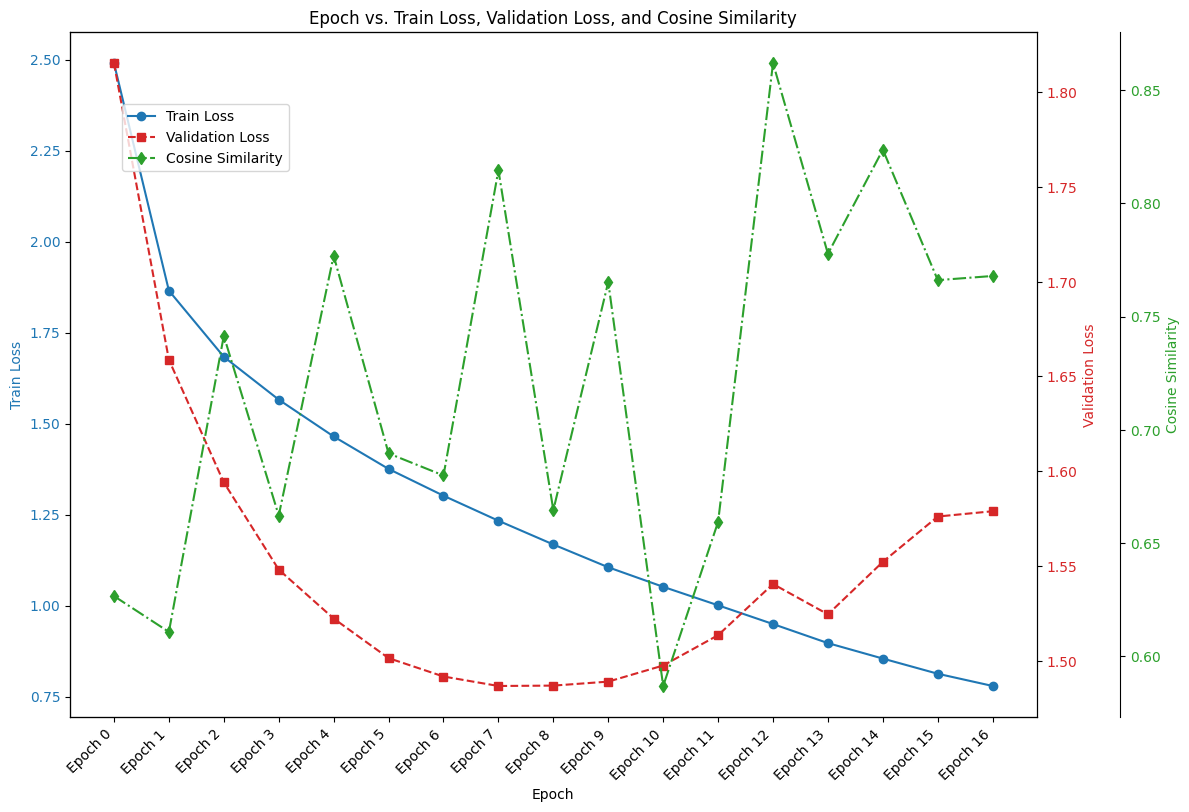

In [27]:
# Visualize the training process of the model

epochs = [
    "simplet5-epoch-12-train-loss-0.9491-val-loss-1.5405",
    "simplet5-epoch-7-train-loss-1.233-val-loss-1.4867",
    "simplet5-epoch-2-train-loss-1.6834-val-loss-1.5941",
    "simplet5-epoch-11-train-loss-1.0006-val-loss-1.5135",
    "simplet5-epoch-6-train-loss-1.3017-val-loss-1.4917",
    "simplet5-epoch-13-train-loss-0.8967-val-loss-1.5245",
    "simplet5-epoch-4-train-loss-1.4645-val-loss-1.5223",
    "simplet5-epoch-10-train-loss-1.0514-val-loss-1.4975",
    "simplet5-epoch-3-train-loss-1.5657-val-loss-1.5481",
    "simplet5-epoch-14-train-loss-0.8542-val-loss-1.5522",
    "simplet5-epoch-15-train-loss-0.8125-val-loss-1.5761",
    "simplet5-epoch-8-train-loss-1.1677-val-loss-1.4869",
    "simplet5-epoch-9-train-loss-1.1051-val-loss-1.4890",
    "simplet5-epoch-16-train-loss-0.7789-val-loss-1.5789",
    "simplet5-epoch-0-train-loss-2.4903-val-loss-1.8153",
    "simplet5-epoch-5-train-loss-1.3753-val-loss-1.5014",
    "simplet5-epoch-1-train-loss-1.8652-val-loss-1.6588"
]

cosine_similarities = [
    0.8617982465980492, 0.814559582030233, 0.7414822898838794, 0.6593842806840363,
    0.6798618549410862, 0.7776923936124253, 0.7768362373100459, 0.5869880094563229,
    0.6621888869560856, 0.823627154485825, 0.7660547794165619, 0.6645936278771558,
    0.765228661458173, 0.767892020756268, 0.6266695790592046, 0.6895926312429574,
    0.6108410339674814
]

# Parse epoch information to extract train loss, val loss, and epoch number
train_losses = [float(ep.split('-train-loss-')[1].split('-val-loss-')[0]) for ep in epochs]
val_losses = [float(ep.split('-val-loss-')[1]) for ep in epochs]
epoch_numbers = [int(ep.split('-')[2]) for ep in epochs]  # Corrected extraction of epoch number

# Combine data into a list of tuples
data = list(zip(epoch_numbers, train_losses, val_losses, cosine_similarities))

# Sort data by epoch number
data_sorted = sorted(data, key=lambda x: x[0])

# Unzip the sorted data
sorted_epoch_numbers, sorted_train_losses, sorted_val_losses, sorted_cosine_similarities = zip(*data_sorted)

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(sorted_epoch_numbers, sorted_train_losses, 'o-', color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(sorted_epoch_numbers)
ax1.set_xticklabels([f'Epoch {num}' for num in sorted_epoch_numbers], rotation=45, ha='right')

ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Validation Loss', color=color)
ax2.plot(sorted_epoch_numbers, sorted_val_losses, 's--', color=color, label='Validation Loss')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # Instantiate a third y-axis that shares the same x-axis
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Cosine Similarity', color=color)
ax3.plot(sorted_epoch_numbers, sorted_cosine_similarities, 'd-.', color=color, label='Cosine Similarity')
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Adjust the layout
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.title('Epoch vs. Train Loss, Validation Loss, and Cosine Similarity')
plt.show()

#### Epoch 12 shows the highest cosine similarity of 0.8617. We will save the model from this epoch and upload it to Kaggle for easier access and future use.

# Saving the model:
Ensure to update the file paths according to your specific directory structure before running this code.

In [28]:
# import shutil

# def zip_folder(folder_to_zip, output_zip_path):
#     # Verify the folder contains files
#     if not os.listdir(folder_to_zip):
#         print(f"The folder {folder_to_zip} is empty.")
#         return

#     # Create a zip file
#     shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', folder_to_zip)
#     print(f"Folder {folder_to_zip} zipped successfully!")

# # Path to the folder you want to zip
# folder_to_zip = '/kaggle/working/outputs/simplet5-epoch-12-train-loss-0.9491-val-loss-1.5405'
# # Path where the zip file will be saved
# output_zip_path = '/kaggle/working/simplet5-epoch-12-train-loss-0.9491-val-loss-1.5405.zip'

# # Verify and zip the folder
# zip_folder(folder_to_zip, output_zip_path)

### After saving and uploading the model to Kaggle, we will now load it.
# Load the model:

In [29]:
# Define the path to the model directory
model_path = '/kaggle/input/fine-tuned-t5/pytorch/t5-base/1'

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Load the model
model = T5ForConditionalGeneration.from_pretrained(model_path)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Let's test the model using a BBC article about [Microsoft and CrowdStrike IT outage](https://www.bbc.com/news/articles/cpe3zgznwjno)

In [30]:
news_article = '''
Microsoft says it estimates that 8.5m computers around the world were disabled by the global IT outage.
It’s the first time a figure has been put on the incident and suggests it could be the worst cyber event in history.
The glitch came from a security company called CrowdStrike which sent out a corrupted software update to its huge number of customers.
Microsoft, which is helping customers recover said in a blog post: "We currently estimate that CrowdStrike’s update affected 8.5 million Windows devices."
The post by David Weston, vice-president at the firm, says this number is less than 1% of all Windows machines worldwide, but that "the broad economic and societal impacts reflect the use of CrowdStrike by enterprises that run many critical services".
The company can be very accurate on how many devices were disabled by the outage as it has performance telemetry to many by their internet connections.
The tech giant - which was keen to point out that this was not an issue with its software - says the incident highlights how important it is for companies such as CrowdStrike to use quality control checks on updates before sending them out.
“It’s also a reminder of how important it is for all of us across the tech ecosystem to prioritize operating with safe deployment and disaster recovery using the mechanisms that exist,” Mr Weston said.
The fall out from the IT glitch has been enormous and was already one of the worst cyber-incidents in history.
The number given by Microsoft means it is probably the largest ever cyber-event, eclipsing all previous hacks and outages.
The closest to this is the WannaCry cyber-attack in 2017 that is estimated to have impacted around 300,000 computers in 150 countries. There was a similar costly and disruptive attack called NotPetya a month later.
There was also a major six-hour outage in 2021 at Meta, which runs Instagram, Facebook and WhatsApp. But that was largely contained to the social media giant and some linked partners.
The massive outage has also prompted warnings by cyber-security experts and agencies around the world about a wave of opportunistic hacking attempts linked to the IT outage.
Cyber agencies in the UK and Australia are warning people to be vigilant to fake emails, calls and websites that pretend to be official.
And CrowdStrike head George Kurtz encouraged users to make sure they were speaking to official representatives from the company before downloading fixes.
"We know that adversaries and bad actors will try to exploit events like this," he said in a blog post.
Whenever there is a major news event, especially one linked to technology, hackers respond by tweaking their existing methods to take into account the fear and uncertainty.
According to researchers at Secureworks, there has already been a sharp rise in CrowdStrike-themed domain registrations – hackers registering new websites made to look official and potentially trick IT managers or members of the public into downloading malicious software or handing over private details.
Cyber security agencies around the world have urged IT responders to only use CrowdStrike's website to source information and help.
The advice is mainly for IT managers who are the ones being affected by this as they try to get their organisations back online.
But individuals too might be targeted, so experts are warning to be to be hyper vigilante and only act on information from the official CrowdStrike channels.
'''

In [31]:
# Prepare the input text for the T5 model
text = 'summarize: ' + news_article
input_ids = tokenizer.encode(text, return_tensors='pt')

# Define generation parameters
max_length = 450  # Maximum length of the generated summary
min_length = 150  # Minimum length of the generated summary
num_beams = 4     # Number of beams for beam search

# Generate the summary with the specified parameters
outputs = model.generate(
    input_ids,
    max_length=max_length,
    min_length=min_length,
    num_beams=num_beams,
    length_penalty=2.0,  # Penalize longer sequences
    early_stopping=True  # Stop beam search when at least `num_beams` sentences are finished
)

# Decode the generated summary
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
summary

'the glitch come from security company called CrowdStrike which send out corrupted software update to its huge number of customers. the tech giant say the incident highlight how important it is for companies such as CrowdStrike to use quality control checks on its update before send them out. the number give by Microsoft means it be probably the largest ever cyber-event eclipsing all previous hack and outage in history. the fall out from the IT glitch has also prompted warning by cyber security experts and agencies around the world about wave of opportunistic hacking attempt linked to the outage. the company say it can be very accurate on how many device were disabled by the outage.'

### The model has successfully summarized the article, which is over 3200 characters long.
### You can experiment with different `max_length`, `min_length`, and `num_beams` parameters to refine the summary.
### This example uses a fine-tuned T5 **Base** model. For potentially better results, consider experimenting with larger and more complex models, as well as larger datasets if available.

## Reflections on the Project

### Challenges Faced

During this project, I encountered several challenges, as it was my first experience with a sequence-to-sequence (seq2seq) model. Initially, I attempted to build an LSTM encoder-decoder model from scratch. Despite experimenting with various depths and complexities, the LSTM model struggled to summarize text coherently. After investing nearly 110 hours into developing the LSTM model, I decided to switch to pre-trained transformers for better results.

### Issues with SimpleT5 Library

I also faced difficulties with the SimpleT5 library, which depends on transformers version 4.16 or lower. Reinstalling the required version of the transformers library proved challenging and led to multiple errors. As a workaround, I modified the file utilities of the current transformers library to make it compatible with SimpleT5.

### Lessons Learned

This project has been a valuable learning experience. I’ve gained significant insights into model fine-tuning and troubleshooting library dependencies. I look forward to tackling future challenges and projects with the knowledge and skills gained from this experience.